## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(4, 5):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:49<00:00,  3.45it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_4"])
layer_hs_array.shape

(10000, 267264)

## Layer 4 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 3.69 s
Outer iteration 0 / 10
  Iteration 19 (10.96 s, search 7.37 s): objective=1911.78 imbalance=1.109 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (21.89 s, search 14.73 s): objective=1908.95 imbalance=1.212 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (32.82 s, search 22.09 s): objective=1906.59 imbalance=1.048 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (43.75 s, search 29.44 s): objective=1908.73 imbalance=1.102 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (54.64 s, search 36.77 s): objective=1908.73 imbalance=1.106 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (65.56 s, search 44.12 s): objective=1905.76 imbalance=1.194 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (76.57 s, search 51.53 s): objective=1897.81 imbalance=1.706 nsplit=0       
Outer it

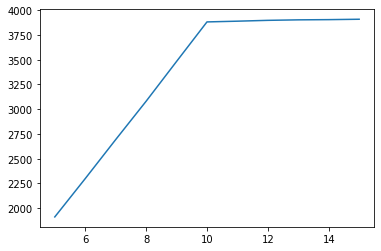

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.12 s
Outer iteration 0 / 10
  Iteration 19 (22.02 s, search 14.71 s): objective=3861.54 imbalance=1.411 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (44.06 s, search 29.45 s): objective=3881.93 imbalance=1.208 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (66.07 s, search 44.19 s): objective=3862.11 imbalance=1.275 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (88.07 s, search 58.93 s): objective=3878.8 imbalance=1.132 nsplit=0        
Outer iteration 4 / 10
  Iteration 19 (110.05 s, search 73.65 s): objective=3845.95 imbalance=2.187 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (132.05 s, search 88.36 s): objective=3872.52 imbalance=1.139 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (154.04 s, search 103.09 s): objective=3878.83 imbalance=1.136 nsplit=0       
Outer ite

3881.9267578125

In [15]:
kmeans.centroids #cluster centers

array([[ 3.3613385e-03,  6.9452915e-05,  5.4682461e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.0281606e-03,  8.3231862e-05,  6.5530366e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.0370976e-03,  8.3416577e-05,  6.5675685e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 3.2767237e-03,  6.7705892e-05,  5.3305989e-03, ...,
        -5.1079278e-06, -2.2581946e-06, -5.3490289e-06],
       [ 3.3346987e-03,  6.8903842e-05,  5.4249149e-03, ...,
        -3.6826816e-05,  1.4191622e-05,  3.0122961e-05],
       [ 3.9051909e-03,  8.0691068e-05,  6.3529857e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000178
1.0000114
1.0000103
1.000035
1.0000101
1.0000126
1.000043
1.0000291
1.0000268
1.0000113


In [17]:
kmeans.obj #inertia at each iteration

array([2404.57641602, 3706.35424805, 3785.09008789, 3817.01782227,
       3833.52441406, 3843.09838867, 3848.06982422, 3851.82739258,
       3856.65673828, 3859.09155273, 3860.69604492, 3861.27490234,
       3861.42333984, 3861.47021484, 3861.4921875 , 3861.50317383,
       3861.50952148, 3861.51977539, 3861.52807617, 3861.53588867,
       2446.88134766, 3711.23925781, 3760.52539062, 3811.64086914,
       3841.48168945, 3852.04321289, 3856.61547852, 3858.9777832 ,
       3860.93188477, 3863.70214844, 3869.67724609, 3876.3684082 ,
       3879.32666016, 3880.7878418 , 3881.30419922, 3881.49047852,
       3881.62231445, 3881.75170898, 3881.84790039, 3881.92675781])

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

0    1568
2    1031
1    1025
3     986
4     879
6     840
8     454
7     452
5     426
9     339
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[2, 6, 1, 6, 5, 3, 3, 9, 10, 10]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 2, 1: 6, 2: 1, 3: 6, 4: 5, 5: 3, 6: 3, 7: 9, 8: 10, 9: 10}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  9,  9, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.2975
Prompt 2 Accuracy:  0.32875
Prompt 3 Accuracy:  0.89375
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.41625
Prompt 6 Accuracy:  0.52
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.2225
Prompt 10 Accuracy:  0.98


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.365875


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

0    378
2    268
1    251
3    248
4    224
6    201
7    129
8    121
5    100
9     80
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1,  9,  3, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.31
Prompt 2 Accuracy:  0.28
Prompt 3 Accuracy:  0.89
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.455
Prompt 6 Accuracy:  0.52
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.28
Prompt 10 Accuracy:  0.99


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.3725


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

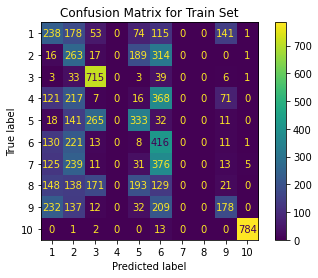

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

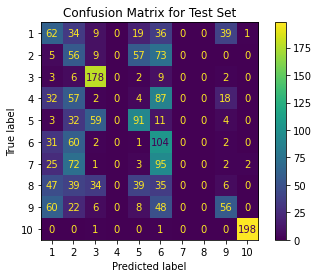

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()